# Notebook showing SVD analysis of candidate library after the refinement step in SODAs

In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator

import sys
import os

# Get the path two folders up
path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
# Add the path to the sys.path
sys.path.append(path_to_add)

from matplotlib import pyplot as plt

### MM chemical reaction system

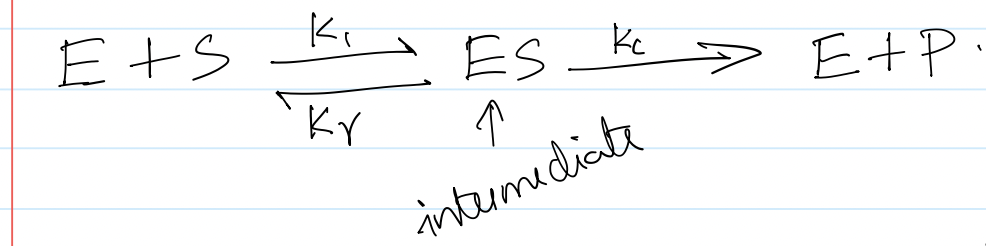

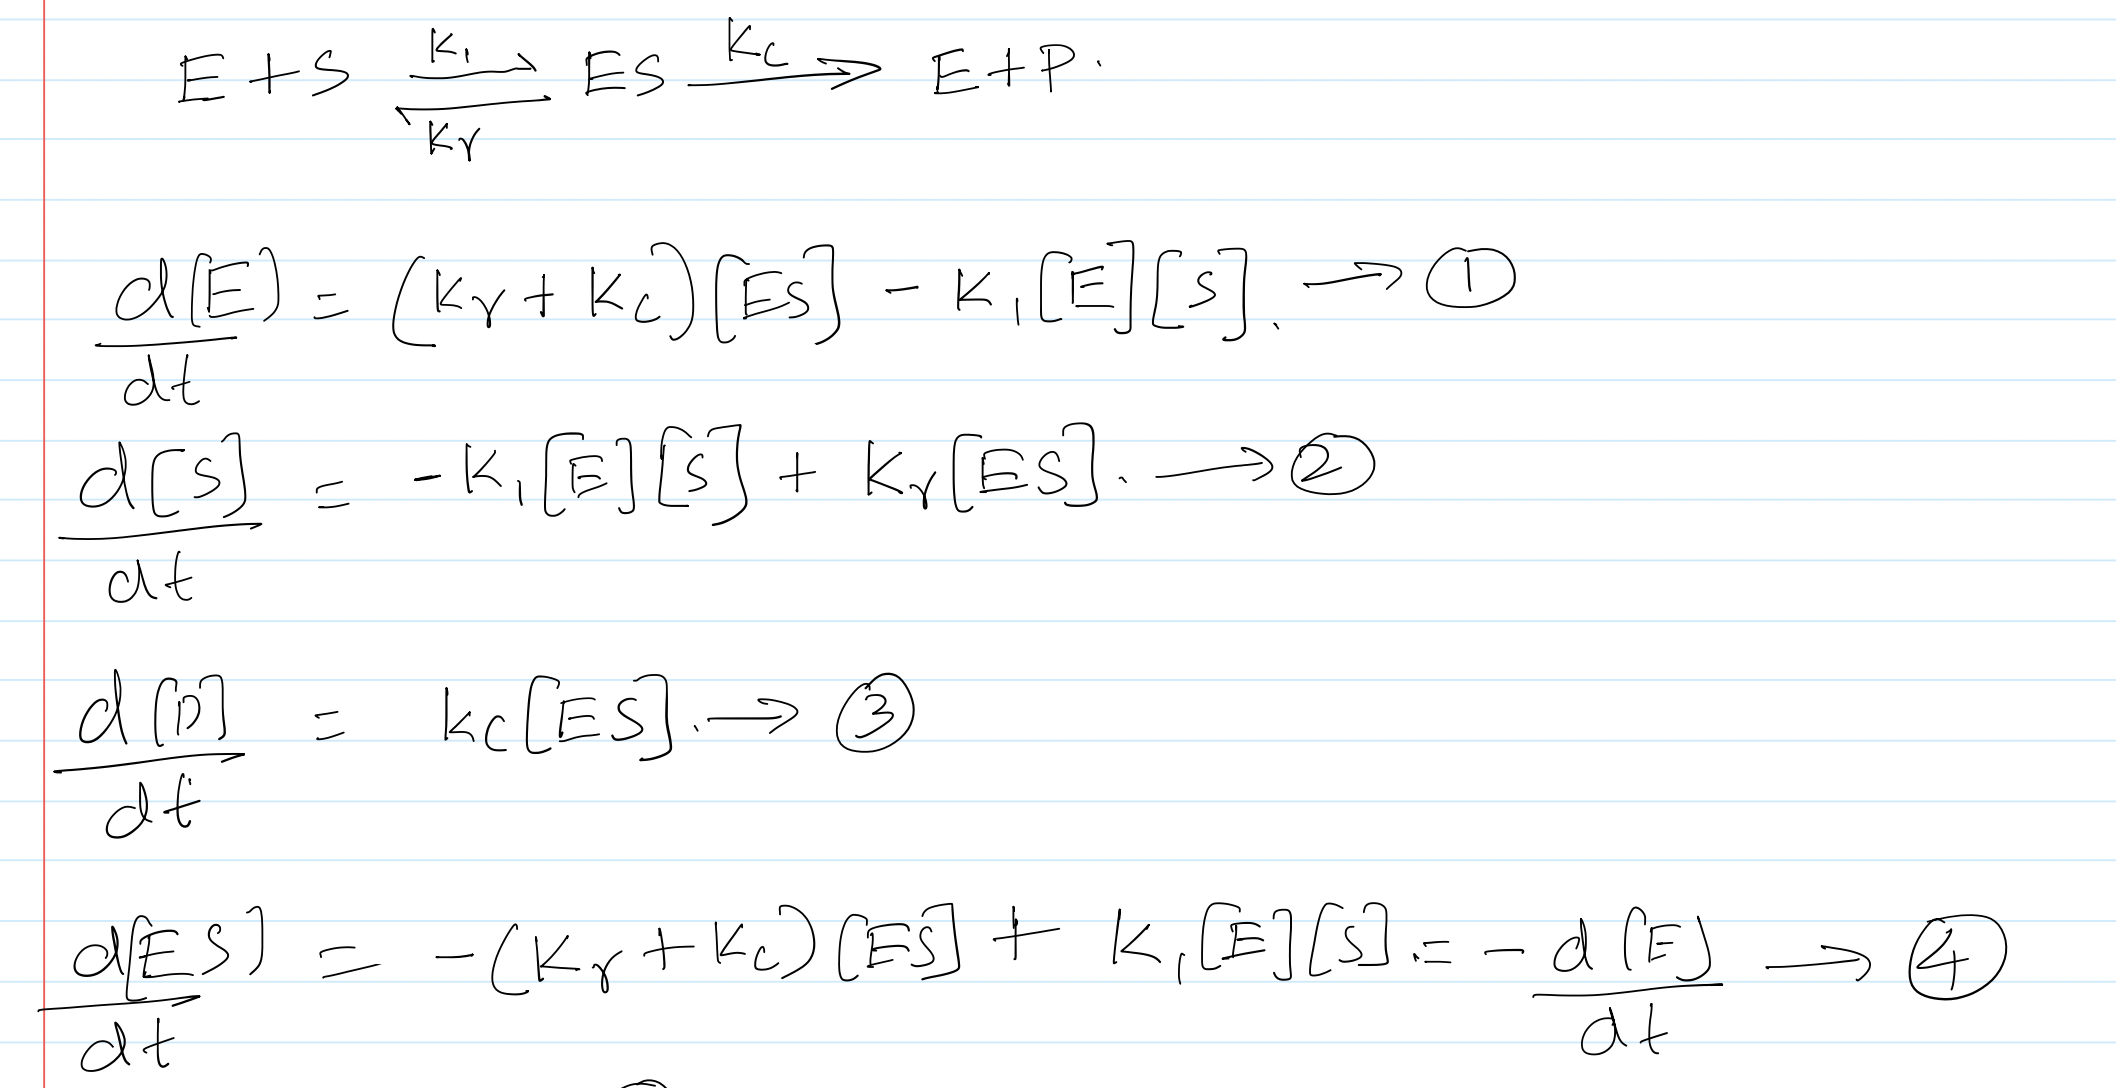

### Michaelis Mentin approximation

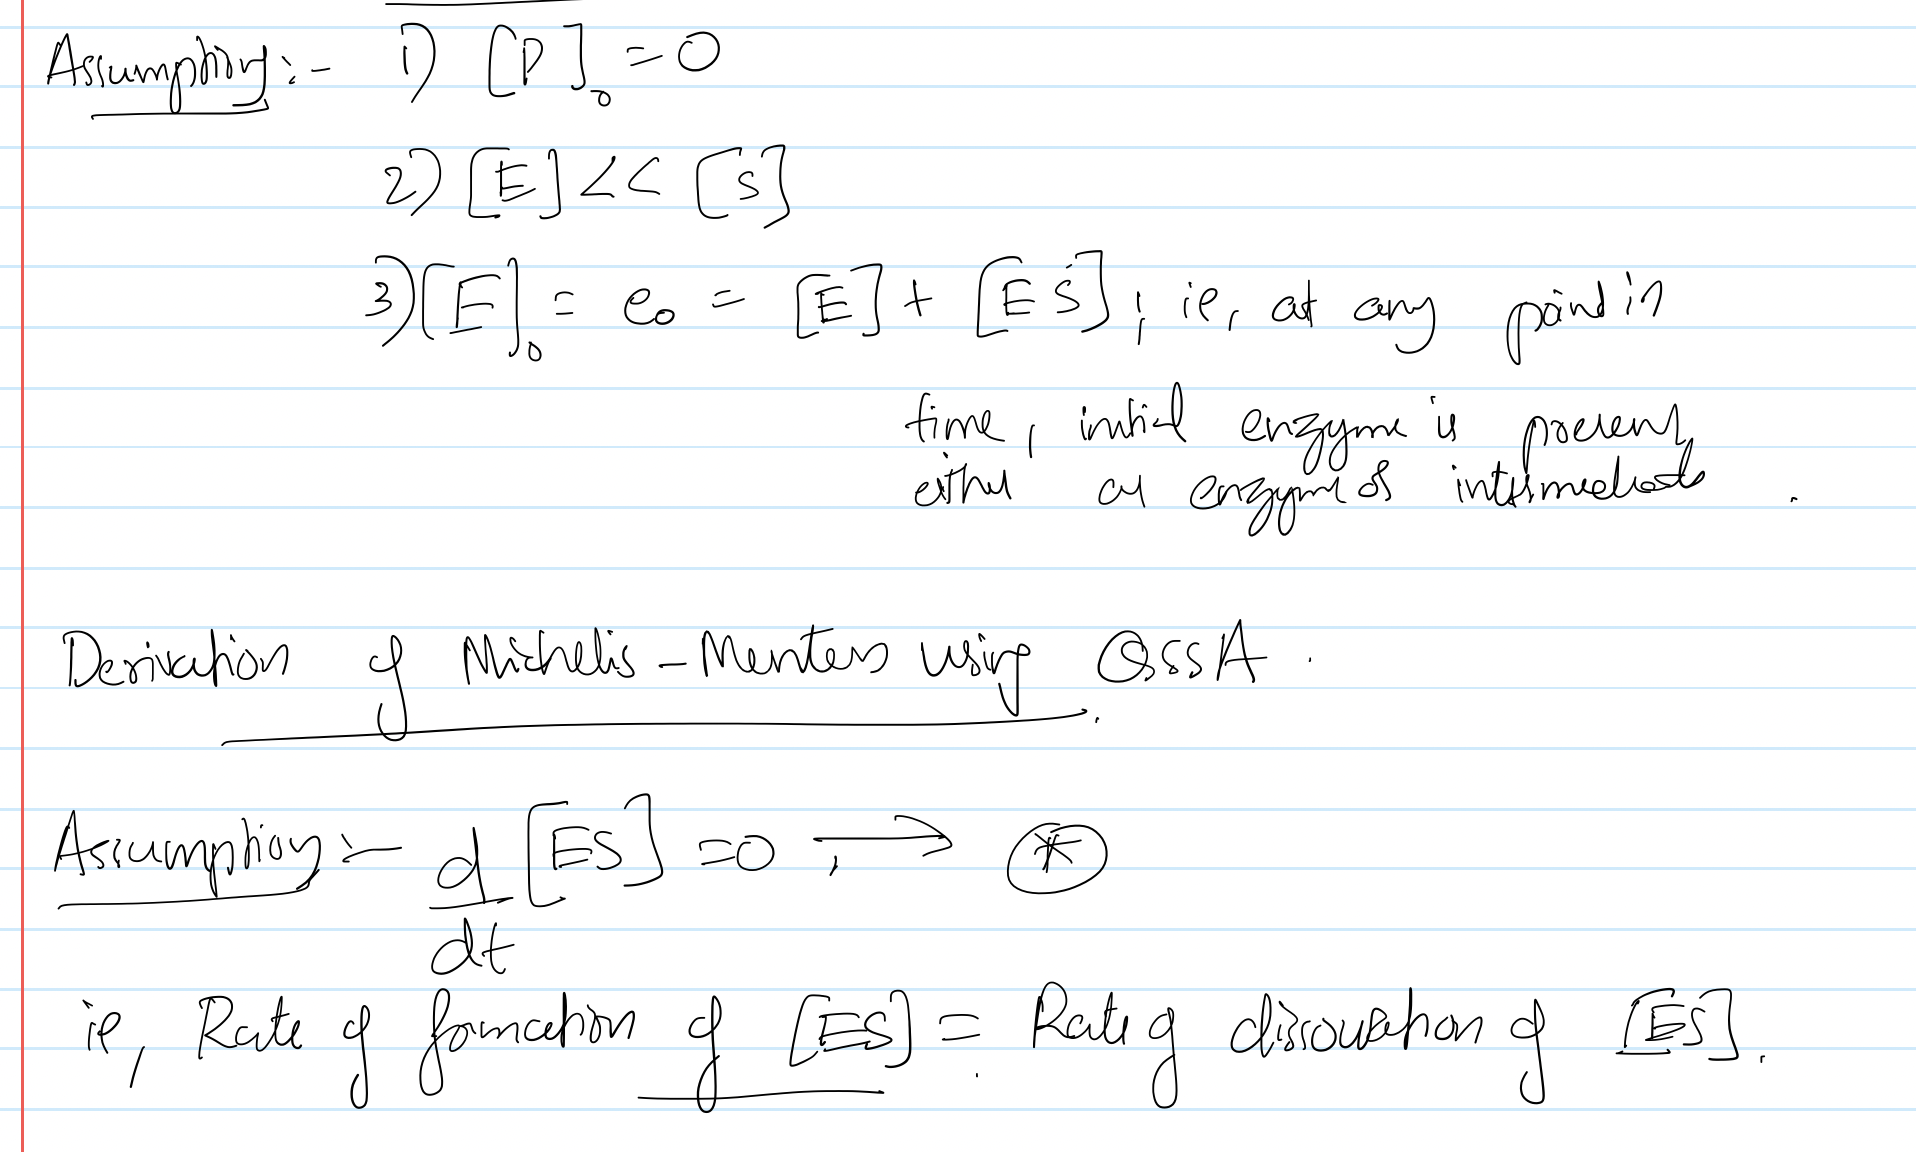

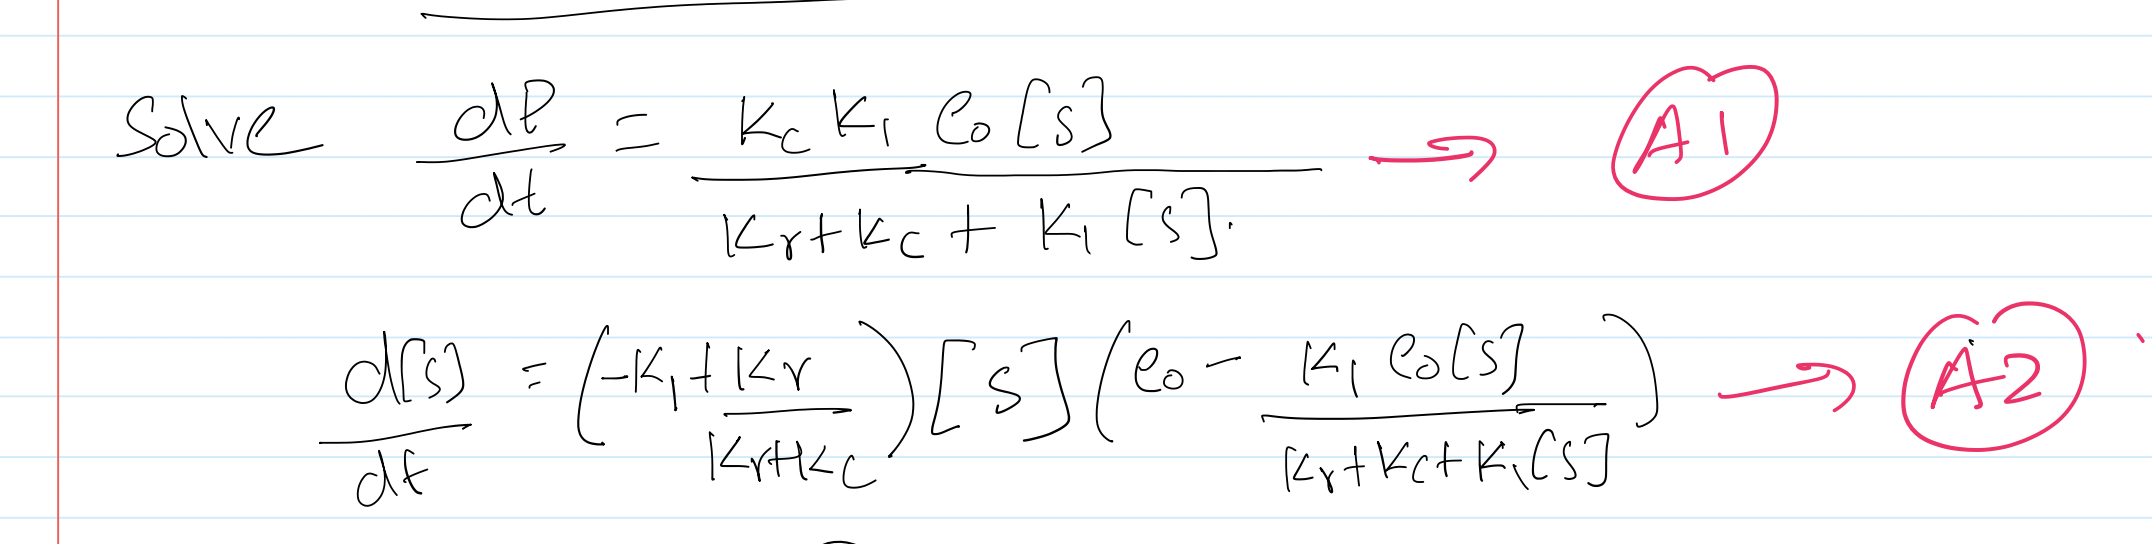

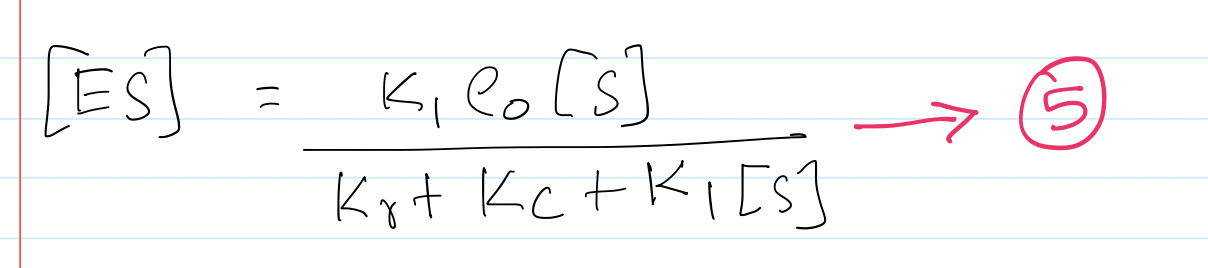

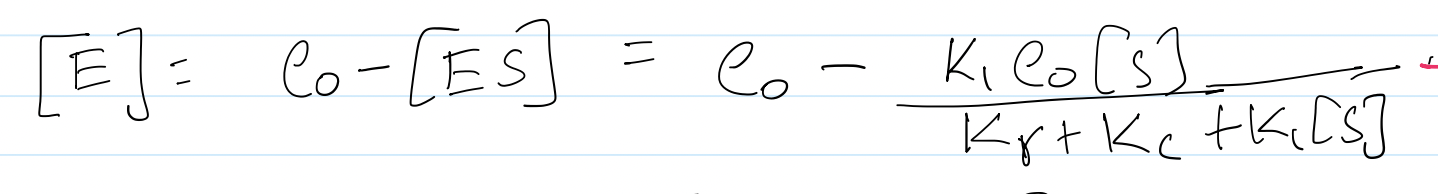


# Generating time series data

#### Loading intial conditions

In [2]:
k_rates_df = pd.read_csv(os.path.join(path_to_add, "parameters/k_rates_param.csv"))

In [3]:
k_rates_df

,k,kr,kcat
0,2.12456000,1.10124000,1.50930000


#### Loading params

In [4]:
IC_df = pd.read_csv(os.path.join(path_to_add, "parameters/init_cond.csv"))

# IC_df = IC_df.drop([2,4,5,8], axis = 0)
# IC_df = IC_df[0:6]
IC_df

,S,E,ES,P
0,2.50000000,2,0,0
1,2.75000000,2,0,0
2,3.00000000,2,0,0
3,3.25000000,2,0,0
4,3.50000000,2,0,0
5,4.00000000,2,0,0
6,4.50000000,2,0,0
7,5.00000000,2,0,0
8,6.00000000,2,0,0
9,6.50000000,2,0,0


In [5]:
from dae_finder import solveMM, plotToy_MM

#### Plotting solutions to different IC

In [6]:
refinement_level = 2
final_time = 4
num_time_points = 500
t_span = (0, final_time)
time_grid_1 = np.linspace(0, final_time, num_time_points)
data_matrix_df_list = []

def get_block_symbol(feature_list):
    return ["[{}]".format(feat) for feat in feature_list]

for k_rate_index in k_rates_df.index:
    k_rates = k_rates_df.loc[k_rate_index]
    for IC_index in IC_df.index:
        IC = IC_df.loc[IC_index]
        # data_matrix_df_list.append(solveMM(IC, k_rates, time_grid_1, "dense"))
        sol = solveMM(IC, k_rates, time_grid_1, "dense")
        sol_df = pd.DataFrame(sol, columns=IC.keys())
        sol_df["t"] = time_grid_1
        data_matrix_df_list.append(sol_df.rename(columns=dict(zip(sol_df.columns, get_block_symbol(sol_df.columns)))))

data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df

,[S],[E],[ES],[P],[t]
0,2.50000000,0.65906583,1.34093417,0.00000000,0.00000000
1,2.48379397,0.66194280,1.33805720,0.01620603,0.00801603
2,2.46762286,0.66483871,1.33516129,0.03237714,0.01603206
3,2.45148688,0.66775370,1.33224630,0.04851312,0.02404810
4,2.43538629,0.67068788,1.32931212,0.06461371,0.03206413
...,...,...,...,...,...
6995,0.70981041,1.26769095,0.73230905,8.79018959,3.96793587
6996,0.70098556,1.27348823,0.72651177,8.79901444,3.97595190
6997,0.69223089,1.27929203,0.72070797,8.80776911,3.98396794
6998,0.68354648,1.28510177,0.71489823,8.81645352,3.99198397


#### Adding noise

In [7]:
from dae_finder import add_noise_to_df
noise_perc = 15


data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["[t]"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["[t]"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df

# Data preprocessing

## Artificial altering sampling frequency

### Sampling more from the transition region (Optional)

- If the aplify_factor = 1, no amplification is done (recommended for initial runs)

## Smoothening data using splines

In [8]:
num_smoothed_points = num_time_points
t_eval_new = np.linspace(data_matrix_df_list[0]["[t]"].iloc[0], data_matrix_df_list[0]["[t]"].iloc[-1], num_smoothed_points)

from dae_finder import smooth_data

#Calling the smoothening function
data_matrix_smooth_df_list = [smooth_data(data_matrix,domain_var="[t]",derr_order=1, noise_perc=noise_perc,
                                          eval_points=t_eval_new) for data_matrix in data_matrix_df_list]

if len(data_matrix_df_list) >1:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
else:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]

data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
if "[t]" in data_matrix_df_smooth:
    data_matrix_df_smooth = data_matrix_df_smooth.drop("[t]", axis=1)

In [9]:
data_matrix_df

,[S],[E],[ES],[P],[t]
0,2.50000000,0.65906583,1.34093417,0.00000000,0.00000000
1,2.48379397,0.66194280,1.33805720,0.01620603,0.00801603
2,2.46762286,0.66483871,1.33516129,0.03237714,0.01603206
3,2.45148688,0.66775370,1.33224630,0.04851312,0.02404810
4,2.43538629,0.67068788,1.32931212,0.06461371,0.03206413
...,...,...,...,...,...
6995,0.70981041,1.26769095,0.73230905,8.79018959,3.96793587
6996,0.70098556,1.27348823,0.72651177,8.79901444,3.97595190
6997,0.69223089,1.27929203,0.72070797,8.80776911,3.98396794
6998,0.68354648,1.28510177,0.71489823,8.81645352,3.99198397


#### Plotting the smoothened splines vs noisy data

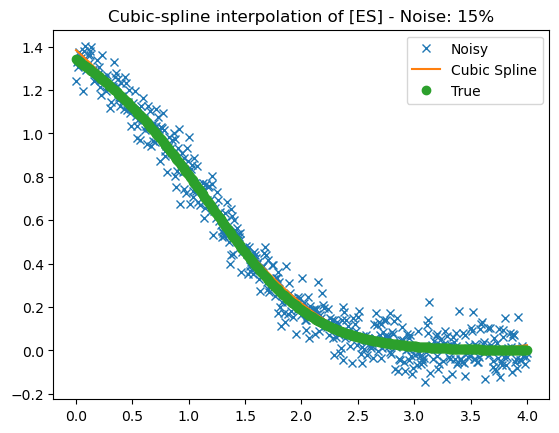

In [10]:
from matplotlib import pyplot as plt
ind = 0
feature_ = "[ES]"

plt.figure()
# plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
#         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

plt.plot(data_matrix_df_list[ind]["[t]"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["[t]"],
         data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["[t]"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
plt.legend(['Noisy', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
plt.show()

In [11]:
data_matrix_df_smooth_appended

,[t],[S],d([S]) /dt,[E],d([E]) /dt,[ES],d([ES]) /dt,[P],d([P]) /dt
0,0.00000000,2.46516015,-1.77754287,0.62528852,0.44747529,1.38363045,-0.44833047,-0.02164866,2.13380960
1,0.00801603,2.45090087,-1.78012870,0.62888949,0.45096333,1.38002256,-0.45183204,-0.00456793,2.12782840
2,0.01603206,2.43662132,-1.78260029,0.63251831,0.45442205,1.37638673,-0.45530431,0.01246475,2.12182089
3,0.02404810,2.42232241,-1.78495763,0.63617474,0.45785147,1.37272317,-0.45874729,0.02944917,2.11578705
4,0.03206413,2.40800507,-1.78720072,0.63985854,0.46125157,1.36903214,-0.46216098,0.04638512,2.10972690
...,...,...,...,...,...,...,...,...,...
6995,3.96793587,0.78150963,-1.02099289,1.27920925,0.76738202,0.73448015,-0.74634924,8.89528606,1.38794003
6996,3.97595190,0.77331481,-1.02367497,1.28537438,0.77081914,0.72848428,-0.74962092,8.90639047,1.38260642
6997,3.98396794,0.76509705,-1.02671849,1.29156710,0.77426483,0.72246216,-0.75290062,8.91745207,1.37726140
6998,3.99198397,0.75685343,-1.03012346,1.29778747,0.77771908,0.71641371,-0.75618834,8.92847078,1.37190497


# Defining Cadidate library (RHS of equations)

### Using polynomial features inspired from mass action kinetics

In [12]:
from dae_finder import PolyFeatureMatrix

poly_degree = 4

poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)


#Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
# in the candidate library
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

,[S],[E],[ES],[P],[S]^2,[S] [E],[S] [ES],[S] [P],[E]^2,[E] [ES],...,[E]^2 [P]^2,[E] [ES]^3,[E] [ES]^2 [P],[E] [ES] [P]^2,[E] [P]^3,[ES]^4,[ES]^3 [P],[ES]^2 [P]^2,[ES] [P]^3,[P]^4
0,2.46516015,0.62528852,1.38363045,-0.02164866,6.07701457,1.54143634,3.41087065,-0.05336741,0.39098573,0.86516823,...,0.00018324,1.65630680,-0.02591503,0.00040547,-0.00000634,3.66505455,-0.05734444,0.00089723,-0.00001404,0.00000022
1,2.45090087,0.62888949,1.38002256,-0.00456793,6.00691508,1.54134581,3.38229850,-0.01119554,0.39550200,0.86788169,...,0.00000825,1.65284794,-0.00547099,0.00001811,-0.00000006,3.62697656,-0.01200543,0.00003974,-0.00000013,0.00000000
2,2.43662132,0.63251831,1.37638673,0.01246475,5.93712345,1.54120761,3.35373324,0.03037188,0.40007942,0.87058981,...,0.00006216,1.64928053,0.01493612,0.00013526,0.00000122,3.58890451,0.03250163,0.00029434,0.00000267,0.00000002
3,2.42232241,0.63617474,1.37272317,0.02944917,5.86764587,1.54102033,3.32517811,0.07133539,0.40471830,0.87329181,...,0.00035099,1.64560393,0.03530331,0.00075737,0.00001625,3.55084619,0.07617667,0.00163423,0.00003506,0.00000075
4,2.40800507,0.63985854,1.36903214,0.04638512,5.79848841,1.54078260,3.29663633,0.11169560,0.40941895,0.87598690,...,0.00088090,1.64181758,0.05562755,0.00188476,0.00006386,3.51280930,0.11901990,0.00403259,0.00013663,0.00000463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.78150963,1.27920925,0.73448015,8.89528606,0.61075731,0.99971435,0.57400331,6.95175176,1.63637631,0.93955380,...,129.48009866,0.50685271,6.13849115,74.34324120,900.37069065,0.29101826,3.52452101,42.68545954,516.96342618,6260.94194371
6996,0.77331481,1.28537438,0.72848428,8.90639047,0.59801580,0.99399905,0.56334769,6.88744368,1.65218730,0.93637503,...,131.05776020,0.49692425,6.07535612,74.27681736,908.10242028,0.28163118,3.44320028,42.09629089,514.66588099,6292.26384180
6997,0.76509705,1.29156710,0.72246216,8.91745207,0.58537349,0.98817417,0.55275366,6.82271623,1.66814556,0.93310835,...,132.65252234,0.48703736,6.01157073,74.20166359,915.88157763,0.27243344,3.36268426,41.50608509,512.31545028,6323.58171151
6998,0.75685343,1.29778747,0.71641371,8.92847078,0.57282712,0.98223490,0.54222017,6.75754375,1.68425231,0.92975273,...,134.26453582,0.47719429,5.94714369,74.11764745,923.70824601,0.26342413,3.28298382,40.91494176,509.91188184,6354.89422831


In [13]:
from matplotlib import pyplot as plt
from sklearn import decomposition



In [14]:
#Adding the features as symbols (Required for library refinement). 
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [15]:
from dae_finder import sequentialThLin, AlgModelFinder
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=True)

algebraic_model_lasso.fit(data_matrix_df_smooth, scale_columns= True)

/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.782e-01, tolerance: 7.000e-01
  model = cd_fast.enet_coordinate_descent(


AlgModelFinder(fit_intercept=True)

# Degree 2

## Refinement 0

In [16]:
#Variance
var_0 = (candidate_lib_full.var()).sum()
var_0

cond_num_0 = np.log(np.linalg.cond(candidate_lib_full.values))
cond_num_0

10.894084629651719

In [17]:
#Best 10 models using R2 metrix
algebraic_model_lasso.best_models(5)

,[E],[ES],[S],[P]
[S],-0.00000000,0.00000000,NaN,-0.25019721
[ES],-0.90088986,NaN,1.57267370,-0.00000000
[P],0.00000000,-0.00000000,-0.09330288,NaN
[E],NaN,-0.89895483,-1.15499935,0.00000000
r2- metric,0.98984366,0.98984366,0.76094634,0.13166997


## Refinement 1

In [18]:
features_to_remove = {E}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

var_1 = (refined_candid_lib.var()).sum()
var_1

cond_num_1 = np.log(np.linalg.cond(refined_candid_lib.values))
cond_num_1

7.143295087601921

In [19]:
algebraic_model_lasso = AlgModelFinder(model_id='RR',
                                       fit_intercept=False, alpha=0.2)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)

AlgModelFinder(alpha=0.2)

In [20]:
algebraic_model_lasso.best_models()

,[S],[S] [ES],[ES]^2,[ES],[S]^2,[ES] [P],[S] [P],[P]^2,[P]
[ES],0.80290898,0.00000000,0.95486369,NaN,0.00000000,0.25453670,0.00000000,-0.00000000,0.69298592
[P],0.00000000,-0.00000000,-0.00000000,0.04056828,-0.00000000,0.29873440,0.00000000,5.02464744,NaN
[S]^2,0.00000000,0.01298962,0.00000000,0.00000000,NaN,-0.00000000,0.00000000,-0.00000000,-0.00000000
[S] [ES],0.38652786,NaN,0.00000000,0.00000000,3.11774083,-0.00000000,0.17958281,-0.00000000,0.00000000
[S] [P],0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.23693788,NaN,0.00000000,0.00000000
[ES]^2,0.00000000,0.00000000,NaN,0.56970199,0.00000000,0.00000000,0.78552799,-0.00000000,0.00000000
[ES] [P],0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,NaN,1.33820454,0.00000000,0.00000000
[P]^2,0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000,0.01223589,-0.00000000,NaN,0.13449854
[S],NaN,1.33782419,0.13628778,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000
r2- metric,0.97189731,0.96389785,0.95123607,0.91263537,0.88524133,0.85027094,0.81774487,0.78277458,0.67750516


In [21]:

best_models_full = algebraic_model_lasso.best_models()

#### Converting the best models to sympy expressions for LHS and RHS

- This will allow us to cancel the common terms on the right hand side if the intercept is close to 0.
- Later on, we will used the simplified LHS and RHS for OLS fit

In [22]:
from dae_finder import get_simplified_equation_list

intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [23]:
simplified_equations

{'[S]': {'lhs': [S],
  'rhs': 0.386527858842362*[ES]*[S] + 0.802908981206795*[ES]},
 '[S] [ES]': {'lhs': [ES], 'rhs': 1.33782418883637},
 '[ES]^2': {'lhs': [ES]**2,
  'rhs': 0.954863693097014*[ES] + 0.136287784252667*[S]},
 '[ES]': {'lhs': 1, 'rhs': 0.569701986493373*[ES]},
 '[S]^2': {'lhs': [S], 'rhs': 3.1177408278547*[ES]},
 '[ES] [P]': {'lhs': [ES]*[P],
  'rhs': 0.254536697440177*[ES] + 0.236937877178333*[P]*[S] + 0.298734399509721*[P]},
 '[S] [P]': {'lhs': [P]*[S],
  'rhs': 0.785527990676604*[ES]**2 + 1.33820453603942*[ES]*[P] + 0.179582805995847*[ES]*[S]},
 '[P]^2': {'lhs': [P], 'rhs': 5.02464743625839},
 '[P]': {'lhs': [P], 'rhs': 0.692985922215081*[ES] + 0.134498544251223*[P]**2}}

#### Creating a list of features that appears on the LHS and RHS of the reduced best fits

In [24]:
from dae_finder import construct_reduced_fit_list

reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

reduced_relationship_features

***Warning: exception occured while trying to find the monomials of 1.33782418883637:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 1:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 5.02464743625839:  Cannot initialize from 'dict' without generators


[['[S]', '[S] [ES]', '[ES]'],
 ['[ES]'],
 ['[ES]^2', '[ES]', '[S]'],
 ['[ES]'],
 ['[S]', '[ES]'],
 ['[ES] [P]', '[ES]', '[S] [P]', '[P]'],
 ['[S] [P]', '[ES]^2', '[ES] [P]', '[S] [ES]'],
 ['[P]'],
 ['[P]', '[ES]', '[P]^2']]

## Refinement 2

In [25]:
#Relationship: 

features_to_remove = {S*ES}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  refined_candid_lib, get_dropped_feat=True)

var_2 = (refined_candid_lib.var()).sum()
var_2

cond_num_2 = np.log(np.linalg.cond(refined_candid_lib.values))
cond_num_2

6.185134473831316

In [26]:
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=False, alpha=0.2)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)

AlgModelFinder(alpha=0.2)

In [27]:
algebraic_model_lasso.best_models()

,[S],[ES]^2,[ES],[ES] [P],[S]^2,[S] [P],[P]^2,[P]
[ES],0.31246954,0.95486369,NaN,0.25453670,-0.00000000,0.00000000,-0.00000000,0.69298194
[P],0.00000000,-0.00000000,0.04056828,0.29873440,-0.05946756,0.00000000,5.02464744,NaN
[S]^2,0.05151394,0.00000000,0.00000000,-0.00000000,NaN,0.00000000,-0.00000000,-0.00000000
[S] [P],0.00000000,0.00000000,0.00000000,0.23693788,-0.00000000,NaN,0.00000000,0.00000000
[ES]^2,0.95808665,NaN,0.56970199,0.00000000,0.00000000,0.71829887,-0.00000000,0.00000000
[ES] [P],0.00000000,0.00000000,0.00000000,NaN,-0.00000000,1.32282774,0.00000000,0.00000000
[P]^2,0.00000000,-0.00000000,0.00000000,0.01223589,-0.00000000,-0.00000000,NaN,0.13449864
[S],NaN,0.13628778,0.00000000,0.00000000,4.94807136,0.33177892,-0.00000000,0.00000000
r2- metric,0.96655129,0.95123607,0.91263537,0.85027094,0.82306590,0.81329888,0.78277458,0.67750499


In [28]:

best_models_full = algebraic_model_lasso.best_models()

#### Converting the best models to sympy expressions for LHS and RHS

- This will allow us to cancel the common terms on the right hand side if the intercept is close to 0.
- Later on, we will used the simplified LHS and RHS for OLS fit

In [29]:
from dae_finder import get_simplified_equation_list

intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [30]:
simplified_equations

{'[S]': {'lhs': [S],
  'rhs': 0.958086645839766*[ES]**2 + 0.312469540719489*[ES] + 0.0515139440438784*[S]**2},
 '[ES]^2': {'lhs': [ES]**2,
  'rhs': 0.954863693097014*[ES] + 0.136287784252667*[S]},
 '[ES]': {'lhs': 1, 'rhs': 0.569701986493373*[ES]},
 '[ES] [P]': {'lhs': [ES]*[P],
  'rhs': 0.254536697440177*[ES] + 0.236937877178333*[P]*[S] + 0.298734399509721*[P]},
 '[S]^2': {'lhs': [S]**2,
  'rhs': -0.0594675593741244*[P] + 4.94807136079737*[S]},
 '[S] [P]': {'lhs': [P]*[S],
  'rhs': 0.718298870691541*[ES]**2 + 1.32282773900376*[ES]*[P] + 0.331778922866657*[S]},
 '[P]^2': {'lhs': [P], 'rhs': 5.02464743625839},
 '[P]': {'lhs': [P], 'rhs': 0.692981938954802*[ES] + 0.134498638597783*[P]**2}}

#### Creating a list of features that appears on the LHS and RHS of the reduced best fits

In [31]:
from dae_finder import construct_reduced_fit_list

reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

reduced_relationship_features

***Warning: exception occured while trying to find the monomials of 1:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 5.02464743625839:  Cannot initialize from 'dict' without generators


[['[S]', '[ES]^2', '[ES]', '[S]^2'],
 ['[ES]^2', '[ES]', '[S]'],
 ['[ES]'],
 ['[ES] [P]', '[ES]', '[S] [P]', '[P]'],
 ['[S]^2', '[P]', '[S]'],
 ['[S] [P]', '[ES]^2', '[ES] [P]', '[S]'],
 ['[P]'],
 ['[P]', '[ES]', '[P]^2']]

## Refinement 3

In [32]:
#Relationship: 

features_to_remove = {S**2}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  refined_candid_lib, get_dropped_feat=True)

var_3 = (refined_candid_lib.var()).sum()
var_3

cond_num_3 = np.log(np.linalg.cond(refined_candid_lib.values))
cond_num_3

5.8529514809818

In [33]:
var_0,var_1,var_2,var_3

(604.0548800406038, 590.9141106099091, 576.4839112805234, 328.9195437316732)

In [34]:
cond_numb_list = cond_num_0, cond_num_1, cond_num_2, cond_num_3
cond_numb_list

(10.894084629651719, 7.143295087601921, 6.185134473831316, 5.8529514809818)

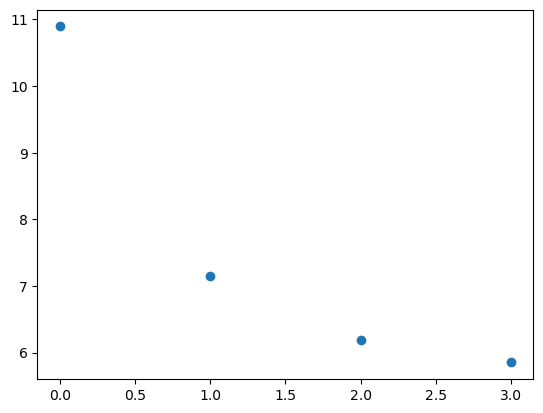

In [35]:
plt.scatter(np.arange(len(cond_numb_list)), cond_numb_list)

# Degree 4

## Refinement 0

In [16]:
#Variance
var_0 = (candidate_lib_full.var()).sum()
var_0

cond_num_0 = np.log(np.linalg.cond(candidate_lib_full.values))
cond_num_0

26.54911325084546

In [17]:
seq_th_model = sequentialThLin(model_id="RR",coef_threshold=0.1, fit_intercept=True, alpha=0.3)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)


#Best 10 models using R2 metrix
algebraic_model_lasso.best_models(5)

# algebraic_model_ridge = AlgModelFinder(model_id='RR',
#                                        fit_intercept=True, alpha=0.3)
algebraic_model_th.fit(candidate_lib_full, scale_columns= True)

algebraic_model_th.best_models(5)


Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential th

,[S]^2 [P],[E] [ES]^2,[S] [P]^2,[S]^3,[E]^2 [ES]
[S],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[E],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[ES],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[S]^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
...,...,...,...,...,...
[ES]^2 [P]^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[ES] [P]^3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[P]^4,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[S]^2 [P],NaN,0.00000000,0.00000000,0.00000000,0.00000000


#### Converting the best models to sympy expressions for LHS and RHS

- This will allow us to cancel the common terms on the right hand side if the intercept is close to 0.
- Later on, we will used the simplified LHS and RHS for OLS fit

In [18]:
from dae_finder import get_simplified_equation_list

best_models_full = algebraic_model_th.best_models()
intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [19]:
simplified_equations

{'[S]^2 [P]': {'lhs': [P]*[S]**2,
  'rhs': 0.498030484733469*[ES]*[P]*[S]**2 + 0.503152080938793*[E]*[P]*[S]**2 - 0.0129233106917908},
 '[E] [ES]^2': {'lhs': [ES],
  'rhs': 0.368761257549852*[ES]**2 + 0.240482998005191*[ES]*[E] - 0.130010039682425*[E]**2 + 0.520713160945657},
 '[S] [P]^2': {'lhs': [P]**2*[S],
  'rhs': 0.500096875476313*[ES]*[P]**2*[S] + 0.497490370425923*[E]*[P]**2*[S] - 0.0115481126977556},
 '[S]^3': {'lhs': [S]**3,
  'rhs': 0.499661859543172*[ES]*[S]**3 + 0.490277224987433*[E]*[S]**3 + 0.031124244488228},
 '[E]^2 [ES]': {'lhs': [E],
  'rhs': -0.1065001468549*[ES]**2 + 0.283728312964629*[ES]*[E] + 0.392308779922171*[E]**2 + 0.430113461662466},
 '[ES] [P]^2': {'lhs': 1,
  'rhs': 0.500371984051227*[ES] + 0.497007459218445*[E]},
 '[ES]^2 [P]': {'lhs': 1, 'rhs': 0.499687764554006*[ES] + 0.4979411589177*[E]},
 '[S]^3 [ES]': {'lhs': [ES]*[S]**3,
  'rhs': 1.07521880405136*[ES]**2*[S]**2 + 1.27236151338943*[S]**3 - 2.06662758261848*[S]**2 + 0.256978079769318},
 '[ES]^3 [P]': 

## Refinement 1

In [20]:
features_to_remove = {E}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

var_1 = (refined_candid_lib.var()).sum()
var_1

cond_num_1 = np.log(np.linalg.cond(refined_candid_lib.values))
cond_num_1

15.163533720506226

In [21]:
seq_th_model = sequentialThLin(model_id="RR",coef_threshold=0.1, fit_intercept=True, alpha=0.3)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)


# algebraic_model_ridge = AlgModelFinder(model_id='RR',
#                                        fit_intercept=True, alpha=0.3)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)

algebraic_model_th.best_models(5)


Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 6 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 8 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential th

,[S]^3 [ES],[S]^2 [ES],[S]^2 [ES]^2,[S]^2 [P],[S] [ES]
[S],0.00000000,0.00000000,0.00000000,0.00000000,0.51753773
[ES],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[S]^2,-2.06662758,0.81956542,0.65063623,0.00000000,0.00000000
[S] [ES],0.00000000,0.00000000,0.00000000,0.00000000,NaN
[S] [P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[ES]^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[ES] [P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[P]^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[S]^3,1.27236151,0.00000000,0.00000000,0.00000000,0.00000000


#### Converting the best models to sympy expressions for LHS and RHS

- This will allow us to cancel the common terms on the right hand side if the intercept is close to 0.
- Later on, we will used the simplified LHS and RHS for OLS fit

In [22]:
from dae_finder import get_simplified_equation_list

best_models_full = algebraic_model_th.best_models()
intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [23]:
simplified_equations

{'[S]^3 [ES]': {'lhs': [ES]*[S]**3,
  'rhs': 1.07521880405136*[ES]**2*[S]**2 + 1.27236151338943*[S]**3 - 2.06662758261848*[S]**2 + 0.256978079769318},
 '[S]^2 [ES]': {'lhs': [ES]*[S]**2,
  'rhs': 0.304716311855903*[ES]**2*[S]**2 + 0.819565415806523*[S]**2 - 0.0771467364353313},
 '[S]^2 [ES]^2': {'lhs': [ES]**2*[S]**2,
  'rhs': 1.53198312582407*[ES]**3*[S] - 2.6232728438069*[ES]**2*[S] + 1.0988281570301*[ES]*[S]**2 + 0.650636231047648*[S]**2 + 0.0272063022368178},
 '[S]^2 [P]': {'lhs': [S],
  'rhs': 0.500475965842252*[ES]*[S] + 0.596713596883642*[ES]},
 '[S] [ES]': {'lhs': [ES]*[S],
  'rhs': -0.142068811010841*[ES]**3*[S] + 0.652505607614327*[ES]**2*[S] + 0.517537730114604*[S] - 0.0301787671966574},
 '[S] [ES] [P]': {'lhs': [ES]*[P]*[S],
  'rhs': 0.369158018009823*[ES]**3*[P] + 0.30969047835273*[ES]**2*[P]*[S] + 0.0833034085792353*[P]*[S]**2 + 0.319950605142071*[P]*[S] - 0.0317676738527478},
 '[S]^2 [ES] [P]': {'lhs': [ES]*[P]*[S]**2,
  'rhs': -1.44835835402776*[ES]**3*[P] + 0.843180702

In [24]:
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=False, alpha=0.2)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)

/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.423e-01, tolerance: 8.647e-01
  model = cd_fast.enet_coordinate_descent(


AlgModelFinder(alpha=0.2)

In [25]:
algebraic_model_lasso.best_models()

,[S] [P],[S],[ES]^2 [P],[ES]^3,[S] [ES] [P],[ES]^2,[S]^2 [P],[S] [ES]^2,[S] [ES]^2 [P],[S] [ES],...,[ES]^2 [P]^2,[ES] [P],[S] [P]^3,[S]^4,[ES] [P]^3,[P]^4,[S]^2 [P]^2,[S]^3 [P],[ES],[P]
[S],0.00000000,NaN,0.00000000,0.01973093,0.00000000,0.00000000,0.00000000,0.50940862,0.00000000,1.17822596,...,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[ES],0.35304225,0.80290391,0.05867123,0.00000000,0.11472009,0.79335217,1.03749754,0.00000000,0.00000000,0.00000000,...,0.00000000,0.24289133,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.69302392
[P],0.00576662,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.20958380,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.04056913,NaN
[S]^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000
[S] [ES],0.00000000,0.38652884,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.74953907,0.00000000,NaN,...,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[ES]^2,0.00000000,0.00000000,0.00000000,0.95188359,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,0.56970085,0.00000000
[ES] [P],0.28626403,0.00000000,0.56647649,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,2.32640823,NaN,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[P]^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,...,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,0.13449764
[S]^3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000
[S]^2 [ES],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000


In [26]:

best_models_full = algebraic_model_lasso.best_models()

#### Converting the best models to sympy expressions for LHS and RHS

- This will allow us to cancel the common terms on the right hand side if the intercept is close to 0.
- Later on, we will used the simplified LHS and RHS for OLS fit

In [27]:
from dae_finder import get_simplified_equation_list

intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [28]:
simplified_equations

{'[S] [P]': {'lhs': [P]*[S],
  'rhs': 0.322733044093129*[ES]**2*[P] + 0.349773885466793*[ES]*[P]*[S] + 0.286264031698648*[ES]*[P] + 0.353042253756799*[ES]},
 '[S]': {'lhs': [S],
  'rhs': 0.386528839932867*[ES]*[S] + 0.802903907004859*[ES]},
 '[ES]^2 [P]': {'lhs': [ES]*[P],
  'rhs': 0.32241940503541*[ES]**2*[P] + 0.566476486645061*[P] + 0.0586712265533871},
 '[ES]^3': {'lhs': [ES], 'rhs': 0.160467488996961*[ES]**2 + 0.951883586870411},
 '[S] [ES] [P]': {'lhs': [ES]*[P]*[S],
  'rhs': 0.23182544696744*[ES]**2*[P]*[S] + 0.114720094017512*[ES] + 0.761474718170745*[P]*[S]},
 '[ES]^2': {'lhs': [ES], 'rhs': 0.243525315165069*[ES]**2 + 0.793352166071404},
 '[S]^2 [P]': {'lhs': [P]*[S]**2,
  'rhs': 0.485564390955893*[ES]**2*[P]*[S] + 0.359509059745931*[ES]*[P]*[S]**2 + 1.03749754365035*[ES]},
 '[S] [ES]^2': {'lhs': [ES]**2,
  'rhs': 0.132318002393304*[ES]**3 + 0.749539069608092*[ES] + 0.509408616367364},
 '[S] [ES]^2 [P]': {'lhs': [ES]**2,
  'rhs': 1.05451320314477*[ES] + 0.095157379596699*[S]},

#### Creating a list of features that appears on the LHS and RHS of the reduced best fits

In [29]:
from dae_finder import construct_reduced_fit_list

reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

reduced_relationship_features

***Warning: exception occured while trying to find the monomials of 1.27665637860155:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 1.42947801030599:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 1.42690665014883:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 3.62631882116549:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 4.53152429808408:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 6.16193398056117:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 1:  Cannot initialize from 'dict' without generators


[['[S] [P]', '[ES]^2 [P]', '[S] [ES] [P]', '[ES] [P]', '[ES]'],
 ['[S]', '[S] [ES]', '[ES]'],
 ['[ES] [P]', '[ES]^2 [P]', '[P]', None],
 ['[ES]', '[ES]^2', None],
 ['[S] [ES] [P]', '[S] [ES]^2 [P]', '[ES]', '[S] [P]'],
 ['[ES]', '[ES]^2', None],
 ['[S]^2 [P]', '[S] [ES]^2 [P]', '[S]^2 [ES] [P]', '[ES]'],
 ['[ES]^2', '[ES]^3', '[ES]', None],
 ['[ES]^2', '[ES]', '[S]'],
 ['[ES]', '[ES]^2', None],
 ['[ES]^2', '[ES]', None],
 ['[S]', '[S] [ES]', None],
 ['[ES]'],
 ['[ES]^4', '[ES]^3', '[S]'],
 ['[ES]'],
 ['[S]', '[ES]^2', '[S] [ES]', '[ES]'],
 ['[ES]^2', '[ES]', None],
 ['[ES]'],
 ['[P]'],
 ['[S] [P]', '[ES]^2 [P]', '[S] [ES] [P]', '[ES]'],
 ['[ES] [P]', '[ES] [P]^2', '[ES]', None],
 ['[P]', '[P]^2', None],
 ['[ES]^3', '[ES]^2', '[S]'],
 ['[S] [ES] [P]', '[ES]^3', '[S]^2 [P]', '[S] [P]'],
 ['[ES]^2 [P]', '[ES]', '[S] [P]'],
 ['[ES] [P]', '[ES]^2 [P]', '[ES]', '[P]'],
 ['[S] [P]', '[ES]^2', '[ES] [P]', '[S]'],
 ['[S]', '[ES]'],
 ['[P]'],
 ['[P]'],
 ['[S] [P]', '[ES]^2', '[ES] [P]'],
 ['[S] 

## Refinement 2

In [30]:
#Relationship: 

features_to_remove = {S*ES}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  refined_candid_lib, get_dropped_feat=True)

var_2 = (refined_candid_lib.var()).sum()
var_2

cond_num_2 = np.log(np.linalg.cond(refined_candid_lib.values))
cond_num_2

13.092591902558002

In [31]:
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=False, alpha=0.2)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)

AlgModelFinder(alpha=0.2)

In [32]:
algebraic_model_lasso.best_models()

,[ES]^2 [P],[ES]^3,[ES]^2,[S],[ES]^4,[S] [P],[P]^3,[S]^3,[ES] [P]^2,[P]^2,...,[S]^2 [P],[ES] [P],[S] [P]^3,[ES] [P]^3,[P]^4,[S]^4,[ES],[S]^3 [P],[S]^2 [P]^2,[P]
[S],0.00000000,0.01973094,0.00000000,NaN,0.37992525,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,...,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[ES],0.05866825,0.00000000,0.79335217,0.86511456,0.00000000,0.46246959,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.24289043,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.69299654
[P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.04561861,0.00000000,0.00000000,0.43353734,3.04468157,...,0.00000000,0.20958385,0.00000000,0.00000000,0.00000000,-0.00000000,0.04056913,-0.00000000,0.00000000,NaN
[S]^2,0.00000000,0.00000000,0.00000000,0.03400407,0.00000000,0.00000000,-0.00000000,3.10435265,-0.00000000,-0.00000000,...,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,1.20038543,0.00000000,-0.00000000
[S] [P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,...,1.72903844,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,0.50507121,0.00000000
[ES]^2,0.00000000,0.95187698,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,0.56970085,0.00000000,0.00000000,0.00000000
[ES] [P],0.56647875,0.00000000,0.00000000,0.00000000,0.00000000,0.02413580,0.00000000,0.00000000,2.01062759,0.00000000,...,0.00000000,NaN,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000
[P]^2,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,3.62631964,-0.00000000,0.00000000,NaN,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,0.13449829
[S]^3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,NaN,-0.00000000,-0.00000000,...,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,6.31735420,0.00000000,0.02229243,-0.00000000,-0.00000000
[S]^2 [P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.03449864,0.00000000,0.00000000,0.00000000,0.00000000,...,NaN,0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,4.02387797,1.16962423,0.00000000


In [33]:

best_models_full = algebraic_model_lasso.best_models()

#### Converting the best models to sympy expressions for LHS and RHS

- This will allow us to cancel the common terms on the right hand side if the intercept is close to 0.
- Later on, we will used the simplified LHS and RHS for OLS fit

In [34]:
from dae_finder import get_simplified_equation_list

intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [35]:
simplified_equations

{'[ES]^2 [P]': {'lhs': [ES]*[P],
  'rhs': 0.32241864619368*[ES]**2*[P] + 0.56647874592321*[P] + 0.0586682490832376},
 '[ES]^3': {'lhs': [ES], 'rhs': 0.160470127735971*[ES]**2 + 0.951876983144027},
 '[ES]^2': {'lhs': [ES], 'rhs': 0.243525315165069*[ES]**2 + 0.793352166071404},
 '[S]': {'lhs': [S],
  'rhs': 0.321158055400059*[ES]**4 + 0.865114558811979*[ES]},
 '[ES]^4': {'lhs': [ES]**4,
  'rhs': 0.92111213620493*[ES]**3 + 0.379925245067529*[S]},
 '[S] [P]': {'lhs': [P]*[S],
  'rhs': 0.406880198523009*[ES]**3*[P] + 0.50150225336252*[ES]**2*[P] + 0.462469592619051*[ES]},
 '[P]^3': {'lhs': [P], 'rhs': 3.62631963958252},
 '[S]^3': {'lhs': [S], 'rhs': 0.0530449583925036*[S]**2 + 3.1043526548517},
 '[ES] [P]^2': {'lhs': [ES]*[P],
  'rhs': 0.0631162862075202*[ES]*[P]**2 + 2.01062759464283*[ES] + 0.433537337193514},
 '[P]^2': {'lhs': [P], 'rhs': 0.0594715753329922*[P]**2 + 3.04468156724919},
 '[S]^2': {'lhs': [S], 'rhs': 0.0639157112044706*[S]**2 + 2.53720507763945},
 '[ES]^3 [P]': {'lhs': [ES]*

#### Creating a list of features that appears on the LHS and RHS of the reduced best fits

In [36]:
from dae_finder import construct_reduced_fit_list

reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

reduced_relationship_features

***Warning: exception occured while trying to find the monomials of 3.62631963958252:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 4.53151633736196:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 6.16193398056116:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 6.31735419563272:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 1:  Cannot initialize from 'dict' without generators


[['[ES] [P]', '[ES]^2 [P]', '[P]', None],
 ['[ES]', '[ES]^2', None],
 ['[ES]', '[ES]^2', None],
 ['[S]', '[ES]^4', '[ES]'],
 ['[ES]^4', '[ES]^3', '[S]'],
 ['[S] [P]', '[ES]^3 [P]', '[ES]^2 [P]', '[ES]'],
 ['[P]'],
 ['[S]', '[S]^2', None],
 ['[ES] [P]', '[ES] [P]^2', '[ES]', None],
 ['[P]', '[P]^2', None],
 ['[S]', '[S]^2', None],
 ['[ES]^3', '[ES]^2', '[S]'],
 ['[S] [P]', '[ES]^2 [P]', '[ES]^2', '[ES]'],
 ['[ES]^2 [P]', '[ES]', '[S] [P]'],
 ['[S]', '[S]^2', None],
 ['[ES] [P]', '[ES]^2 [P]', '[ES]', '[P]'],
 ['[S] [P]', '[ES]^2', '[ES] [P]', '[S]'],
 ['[P]'],
 ['[P]'],
 ['[S]'],
 ['[ES]'],
 ['[S] [P]', '[P]', None],
 ['[S]^2 [P]', '[ES]^3', '[S] [P]', '[S]^2', '[S]'],
 ['[P]', '[ES]', '[P]^2']]

## Refinement 3

In [37]:
#Relationship: 

# features_to_remove = {S**2}
features_to_remove = {ES**2*P}


features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  refined_candid_lib, get_dropped_feat=True)

var_3 = (refined_candid_lib.var()).sum()
var_3

cond_num_3 = np.log(np.linalg.cond(refined_candid_lib.values))
cond_num_3

12.597841316489689

In [38]:
seq_th_model = sequentialThLin(model_id="RR",coef_threshold=0.1, fit_intercept=True, alpha=0.3)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)


# algebraic_model_ridge = AlgModelFinder(model_id='RR',
#                                        fit_intercept=True, alpha=0.3)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)

algebraic_model_th.best_models(5)


Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 5 iterations


,[S]^3,[P]^3,[ES] [P],[S] [P],[ES]^2
[S],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[ES],0.00000000,0.00000000,1.65535193,-1.40322016,0.38344236
[P],0.00000000,-10.32863822,0.59962124,0.00000000,0.00000000
[S]^2,5.30259378,0.00000000,0.00000000,0.00000000,0.00000000
[S] [P],0.00000000,0.00000000,0.28287364,NaN,0.00000000
[ES]^2,0.00000000,0.00000000,-0.65130804,1.57087487,NaN
[ES] [P],0.00000000,0.00000000,NaN,1.02416936,0.00000000
[P]^2,0.00000000,5.44852418,-0.11296725,0.00000000,0.00000000
[S]^2 [P],0.00000000,0.00000000,-0.01684087,0.18875225,0.00000000
[S] [P]^2,0.00000000,0.00000000,-0.02440721,0.09017413,0.00000000


#### Converting the best models to sympy expressions for LHS and RHS

- This will allow us to cancel the common terms on the right hand side if the intercept is close to 0.
- Later on, we will used the simplified LHS and RHS for OLS fit

In [39]:
from dae_finder import get_simplified_equation_list

best_models_full = algebraic_model_th.best_models()
intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [40]:
simplified_equations

{'[S]^3': {'lhs': [S]**3,
  'rhs': -5.97989688044312*[ES]**4 + 0.0550724855225234*[S]**4 + 5.30259377990733*[S]**2 - 0.152075755907935},
 '[P]^3': {'lhs': [P]**3,
  'rhs': 0.0588948980271023*[P]**4 + 5.44852417774351*[P]**2 - 10.328638216559*[P] + 4.50635865374811},
 '[ES] [P]': {'lhs': [ES]*[P],
  'rhs': -0.651308037654539*[ES]**2 + 0.163635807159778*[ES]*[P]**2 + 1.65535192995778*[ES] - 0.112967246547414*[P]**2 + 0.282873642988532*[P]*[S] + 0.599621244230777*[P] - 0.949507099771597},
 '[S] [P]': {'lhs': [P]*[S],
  'rhs': -0.269846927614215*[ES]**4 + 1.57087486602062*[ES]**2 - 0.099230477080925*[ES]*[P]**2 + 1.02416936113978*[ES]*[P] - 1.40322016051088*[ES] + 0.0901741261378903*[P]**2*[S] + 0.188752245793899*[P]*[S]**2 + 0.0103034740256931},
 '[ES]^2': {'lhs': [ES]**2,
  'rhs': -0.23281111816947*[ES]**4 + 0.854296751149033*[ES]**3 + 0.383442362898677*[ES] - 0.0200082845873374},
 '[S] [P]^2': {'lhs': [P]**2*[S],
  'rhs': -0.0913025896428106*[ES]*[P]**3 + 1.20730927649886*[ES]*[P]**2 - 

## Refinement 4

In [41]:
#Relationship: 

# features_to_remove = {S**2}
features_to_remove = {ES**4}


features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  refined_candid_lib, get_dropped_feat=True)

var_4 = (refined_candid_lib.var()).sum()
var_4

cond_num_4 = np.log(np.linalg.cond(refined_candid_lib.values))
cond_num_4

12.575855346553505

In [42]:
seq_th_model = sequentialThLin(model_id="RR",coef_threshold=0.1, fit_intercept=True, alpha=0.3)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)


# algebraic_model_ridge = AlgModelFinder(model_id='RR',
#                                        fit_intercept=True, alpha=0.3)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)

algebraic_model_th.best_models(5)


Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 5 iterations


,[S]^3,[P]^3,[ES] [P],[S] [P],[S] [P]^2
[S],-11.54308777,0.00000000,0.00000000,0.00000000,0.00000000
[ES],0.00000000,0.00000000,1.65535193,-1.61554529,0.00000000
[P],0.00000000,-10.32863822,0.59962124,0.00000000,0.00000000
[S]^2,6.31097888,0.00000000,0.00000000,0.00000000,0.00000000
[S] [P],0.00000000,0.00000000,0.28287364,NaN,2.48783230
[ES]^2,20.75943464,0.00000000,-0.65130804,2.39448942,0.00000000
[ES] [P],0.00000000,0.00000000,NaN,1.01436122,-2.94114530
[P]^2,0.00000000,5.44852418,-0.11296725,0.00000000,0.00000000
[S]^2 [P],0.00000000,0.00000000,-0.01684087,0.19177248,-0.21333491
[S] [P]^2,0.00000000,0.00000000,-0.02440721,0.09086171,NaN


#### Converting the best models to sympy expressions for LHS and RHS

- This will allow us to cancel the common terms on the right hand side if the intercept is close to 0.
- Later on, we will used the simplified LHS and RHS for OLS fit

In [43]:
from dae_finder import get_simplified_equation_list

best_models_full = algebraic_model_th.best_models()
intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [44]:
simplified_equations

{'[S]^3': {'lhs': [S]**3,
  'rhs': -14.4063367148729*[ES]**3 + 20.7594346395534*[ES]**2 + 0.0516737217494732*[S]**4 + 6.31097888327682*[S]**2 - 11.5430877685482*[S] + 0.185646319939006},
 '[P]^3': {'lhs': [P]**3,
  'rhs': 0.0588948980271023*[P]**4 + 5.44852417774351*[P]**2 - 10.328638216559*[P] + 4.50635865374811},
 '[ES] [P]': {'lhs': [ES]*[P],
  'rhs': -0.651308037654539*[ES]**2 + 0.163635807159778*[ES]*[P]**2 + 1.65535192995778*[ES] - 0.112967246547414*[P]**2 + 0.282873642988532*[P]*[S] + 0.599621244230777*[P] - 0.949507099771597},
 '[S] [P]': {'lhs': [P]*[S],
  'rhs': -0.86730731986272*[ES]**3 + 2.39448941992434*[ES]**2 - 0.0992910598208978*[ES]*[P]**2 + 1.01436122109921*[ES]*[P] - 1.6155452900083*[ES] + 0.0908617115615056*[P]**2*[S] + 0.191772480956059*[P]*[S]**2 + 0.0185073395410111},
 '[S] [P]^2': {'lhs': [P]**2*[S],
  'rhs': -0.0913025896428106*[ES]*[P]**3 + 1.20730927649886*[ES]*[P]**2 - 2.94114529532703*[ES]*[P] + 0.0685929460503725*[P]**3*[S] + 0.0671535305910634*[P]**2*[S]*

## Refinement 5

In [46]:
#Relationship: 

# features_to_remove = {S**2}
features_to_remove = {S**4}


features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  refined_candid_lib, get_dropped_feat=True)

var_5 = (refined_candid_lib.var()).sum()
var_5

cond_num_5 = np.log(np.linalg.cond(refined_candid_lib.values))
cond_num_5

12.154716209268065

In [47]:
var_0,var_1,var_2,var_3,var_4,var_5

(2161421.4829220218,
 2131623.867084052,
 2080697.2401782484,
 2080202.7751818043,
 2080194.5063761752,
 1164207.6790929816)

In [48]:
cond_numb_list = cond_num_0, cond_num_1, cond_num_2, cond_num_3, cond_num_4, cond_num_5
cond_numb_list

(26.54911325084546,
 15.163533720506226,
 13.092591902558002,
 12.597841316489689,
 12.575855346553505,
 12.154716209268065)

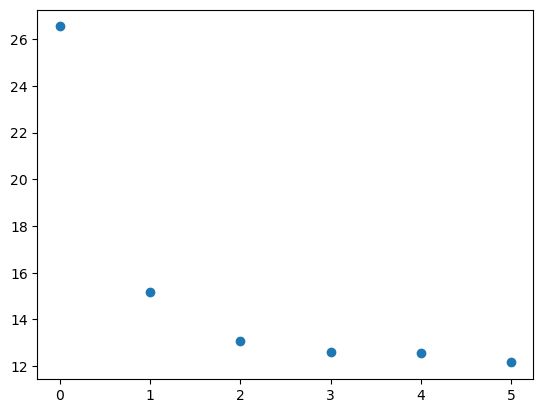

In [49]:
plt.scatter(np.arange(len(cond_numb_list)), cond_numb_list)

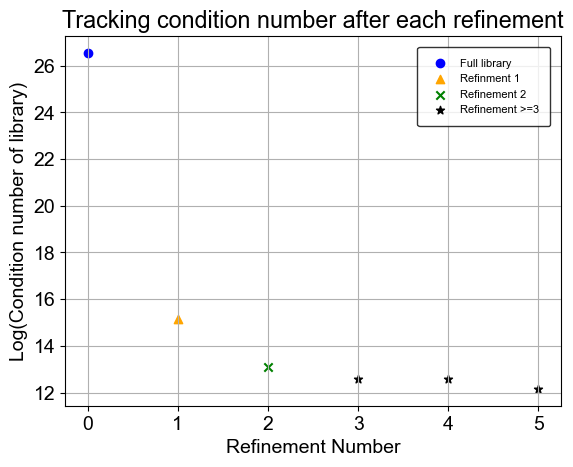

In [55]:
symbols = ['o', '^', 'x', '*', '*','*']  # Circle, square, triangle, diamond, plus
colors = ['blue', 'orange', 'green', 'black', 'black', 'black']
labels = ['Full library', 'Refinment 1', 'Refinement 2','Refinement >=3','','' ]


# Plot each point with a specific marker
for i in range(len(cond_numb_list)):
    plt.scatter([i], cond_numb_list[i], marker=symbols[i], label=labels[i], color=colors[i] )

# plt.scatter(np.arange(len(cond_numb_list)), cond_numb_list, label="Log of Condition Number of Refined Library", marker='o')
# plt.scatter(np.arange(1, len(sing_vals_2)+1),find_log_values(sing_vals_2), label="Full library - {factors of [E]}", marker='^')
# plt.scatter(np.arange(1, len(sing_vals_4)+1),find_log_values(sing_vals_4), label="Full library - {factors of [E] and [S][ES]}",
            # marker='x')
# plt.xticks(range(1, len(sing_vals_1)+1, 1))
# plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)

# plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')

# plt.xticks(range(1, len(sing_vals_1)+1, 1))
# plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)

plt.grid()
plt.title("Tracking condition number after each refinement")
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Refinement Number')
plt.ylabel('Log(Condition number of library)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)

plt.savefig('figures/svd_refinement.svg', format='svg', bbox_inches='tight')

# Degree 2 new

## Refinement 0

In [16]:
#Variance
var_0 = (candidate_lib_full.var()).sum()
var_0

cond_num_0 = np.log(np.linalg.cond(candidate_lib_full.values))
cond_num_0

39.7724730941629

In [17]:
seq_th_model = sequentialThLin(model_id="lasso",coef_threshold=0.1, fit_intercept=True, alpha=0.3)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)


#Best 10 models using R2 metrix
algebraic_model_lasso.best_models(5)

# algebraic_model_ridge = AlgModelFinder(model_id='RR',
#                                        fit_intercept=True, alpha=0.3)
algebraic_model_th.fit(candidate_lib_full, scale_columns= True)

algebraic_model_th.best_models(5)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


,[E],[ES],[S] [E],[S],[S] [ES]
[S],0.00000000,0.00000000,0.00000000,NaN,1.19431229
[ES],-0.70000000,NaN,0.00000000,0.00000000,0.00000000
[P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[S]^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[S] [E],0.00000000,0.00000000,NaN,0.00000000,0.00000000
[S] [ES],0.00000000,0.00000000,0.00000000,0.40481035,NaN
[S] [P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[E]^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[E] [ES],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[E] [P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


#### Converting the best models to sympy expressions for LHS and RHS

- This will allow us to cancel the common terms on the right hand side if the intercept is close to 0.
- Later on, we will used the simplified LHS and RHS for OLS fit

In [18]:
from dae_finder import get_simplified_equation_list

best_models_full = algebraic_model_th.best_models()
intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [19]:
simplified_equations

{'[E]': {'lhs': [E], 'rhs': 1.73862053068448 - 0.7*[ES]},
 '[ES]': {'lhs': [ES], 'rhs': 1.66162235248188 - 0.7*[E]},
 '[S] [E]': {'lhs': [E]*[S], 'rhs': 2.04170822007759 - 0.860120683812178*[E]},
 '[S]': {'lhs': [S], 'rhs': 0.40481034911291*[ES]*[S] + 0.808456340344394},
 '[S] [ES]': {'lhs': [ES]*[S], 'rhs': 1.19431228625211*[S] + 0.51520298668918},
 '[ES]^2': {'lhs': [ES]**2,
  'rhs': -0.732713294129469*[E] + 0.128863549471394*[S] + 1.69366490933936},
 '[E]^2': {'lhs': [E]**2, 'rhs': 1.6285960266745*[E] - 0.203795032681268},
 '[S]^2': {'lhs': [S]**2,
  'rhs': 2.77028643622416*[ES]*[S] + 0.802659497047766},
 '[P]': {'lhs': [P], 'rhs': 0.0792327403311253*[P]**2 + 2.18149181326602},
 '[P]^2': {'lhs': [P]**2, 'rhs': 5.45372144705352*[P] - 2.98961193933315},
 '[E] [P]': {'lhs': [E]*[P],
  'rhs': 1.91670866042104*[E] + 0.579563883834105*[P] + 0.0193743094670289},
 '[ES] [P]': {'lhs': [ES]*[P],
  'rhs': 0.21974234514224*[P]*[S] + 1.1178866890939},
 '[S] [P]': {'lhs': [P]*[S],
  'rhs': 0.9979

## Refinement 1

In [20]:
features_to_remove = {E}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

var_1 = (refined_candid_lib.var()).sum()
var_1

cond_num_1 = np.log(np.linalg.cond(refined_candid_lib.values))
cond_num_1

38.00008979944747

In [21]:
seq_th_model = sequentialThLin(model_id="lasso",coef_threshold=0.1, fit_intercept=True, alpha=0.3)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)


# algebraic_model_ridge = AlgModelFinder(model_id='RR',
#                                        fit_intercept=True, alpha=0.3)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)

algebraic_model_th.best_models(5)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


,[S],[S] [ES],[ES]^2,[ES],[S]^2
[ES],0.00000000,0.00000000,0.73271329,NaN,0.00000000
[P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[S]^2,0.00000000,0.00000000,0.00000000,0.00000000,NaN
[S] [ES],0.40481035,NaN,0.00000000,0.00000000,2.77028644
[S] [P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[ES]^2,0.00000000,0.00000000,NaN,0.39073149,0.00000000
[ES] [P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[P]^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[S],NaN,1.19431229,0.12886355,0.00000000,0.00000000
r2- metric,0.90066200,0.90066200,0.88869750,0.84797607,0.84116482


#### Converting the best models to sympy expressions for LHS and RHS

- This will allow us to cancel the common terms on the right hand side if the intercept is close to 0.
- Later on, we will used the simplified LHS and RHS for OLS fit

In [22]:
from dae_finder import get_simplified_equation_list

best_models_full = algebraic_model_th.best_models()
intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [23]:
simplified_equations

{'[S]': {'lhs': [S], 'rhs': 0.40481034911291*[ES]*[S] + 0.808456340344394},
 '[S] [ES]': {'lhs': [ES]*[S], 'rhs': 1.19431228625211*[S] + 0.51520298668918},
 '[ES]^2': {'lhs': [ES]**2,
  'rhs': 0.732713294129469*[ES] + 0.128863549471394*[S] + 0.228133636536362},
 '[ES]': {'lhs': [ES], 'rhs': 0.390731491509634*[ES]**2 + 0.433889634134591},
 '[S]^2': {'lhs': [S]**2,
  'rhs': 2.77028643622416*[ES]*[S] + 0.802659497047766},
 '[P]': {'lhs': [P], 'rhs': 0.0792327403311253*[P]**2 + 2.18149181326602},
 '[P]^2': {'lhs': [P]**2, 'rhs': 5.45372144705352*[P] - 2.98961193933315},
 '[ES] [P]': {'lhs': [ES]*[P],
  'rhs': 0.21974234514224*[P]*[S] + 1.1178866890939},
 '[S] [P]': {'lhs': [P]*[S],
  'rhs': 0.997944408688229*[ES]**2 + 1.13495682159755*[ES]*[P] + 0.941212406643361}}

## Refinement 2

In [24]:
#Relationship: 

features_to_remove = {S*ES}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  refined_candid_lib, get_dropped_feat=True)

var_2 = (refined_candid_lib.var()).sum()
var_2

cond_num_2 = np.log(np.linalg.cond(refined_candid_lib.values))
cond_num_2

6.243259710295879

In [25]:
seq_th_model = sequentialThLin(model_id="lasso",coef_threshold=0.1, fit_intercept=True, alpha=0.3)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)


# algebraic_model_ridge = AlgModelFinder(model_id='RR',
#                                        fit_intercept=True, alpha=0.3)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)

algebraic_model_th.best_models(5)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


,[S],[ES]^2,[ES],[P],[P]^2
[ES],0.00000000,0.73271329,NaN,0.00000000,0.00000000
[P],0.00000000,0.00000000,0.00000000,NaN,5.45372145
[S]^2,0.04780080,0.00000000,0.00000000,0.00000000,0.00000000
[S] [P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[ES]^2,0.81378895,NaN,0.39073149,0.00000000,0.00000000
[ES] [P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[P]^2,0.00000000,0.00000000,0.00000000,0.07923274,NaN
[S],NaN,0.12886355,0.00000000,0.00000000,0.00000000
r2- metric,0.89753105,0.88869750,0.84797607,0.82652525,0.82652525


#### Converting the best models to sympy expressions for LHS and RHS

- This will allow us to cancel the common terms on the right hand side if the intercept is close to 0.
- Later on, we will used the simplified LHS and RHS for OLS fit

In [26]:
from dae_finder import get_simplified_equation_list

best_models_full = algebraic_model_th.best_models()
intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [27]:
simplified_equations

{'[S]': {'lhs': [S], 'rhs': 0.813788948664695*[ES]**2 + 0.63902545650918},
 '[ES]^2': {'lhs': [ES]**2,
  'rhs': 0.732713294129469*[ES] + 0.128863549471394*[S] + 0.228133636536362},
 '[ES]': {'lhs': [ES], 'rhs': 0.390731491509634*[ES]**2 + 0.433889634134591},
 '[P]': {'lhs': [P], 'rhs': 0.0792327403311253*[P]**2 + 2.18149181326602},
 '[P]^2': {'lhs': [P]**2, 'rhs': 5.45372144705352*[P] - 2.98961193933315},
 '[S]^2': {'lhs': [S]**2, 'rhs': 4.58418038969074*[S] - 0.281645306682282},
 '[ES] [P]': {'lhs': [ES]*[P],
  'rhs': 0.21974234514224*[P]*[S] + 1.1178866890939},
 '[S] [P]': {'lhs': [P]*[S],
  'rhs': 0.997944408688229*[ES]**2 + 1.13495682159755*[ES]*[P] + 0.941212406643361}}

## Refinement 3

In [28]:
#Relationship: 

features_to_remove = {S**2}
# features_to_remove = {ES**2}


features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  refined_candid_lib, get_dropped_feat=True)

var_3 = (refined_candid_lib.var()).sum()
var_3

cond_num_3 = np.log(np.linalg.cond(refined_candid_lib.values))
cond_num_3

5.907383114458975

In [29]:
seq_th_model = sequentialThLin(model_id="lasso",coef_threshold=0.1, fit_intercept=True, alpha=0.3)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)


# algebraic_model_ridge = AlgModelFinder(model_id='RR',
#                                        fit_intercept=True, alpha=0.3)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)

algebraic_model_th.best_models(5)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


,[ES]^2,[ES],[P],[P]^2,[S]
[S],0.12886355,0.00000000,0.00000000,0.00000000,NaN
[ES],0.73271329,NaN,0.00000000,0.00000000,0.00000000
[P],0.00000000,0.00000000,NaN,5.45372145,0.00000000
[S] [P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[ES] [P],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[P]^2,0.00000000,0.00000000,0.07923274,NaN,0.00000000
[ES]^2,NaN,0.39073149,0.00000000,0.00000000,1.39242295
r2- metric,0.88869750,0.84797607,0.82652525,0.82652525,0.80962806


#### Converting the best models to sympy expressions for LHS and RHS

- This will allow us to cancel the common terms on the right hand side if the intercept is close to 0.
- Later on, we will used the simplified LHS and RHS for OLS fit

In [30]:
from dae_finder import get_simplified_equation_list

best_models_full = algebraic_model_th.best_models()
intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [31]:
simplified_equations

{'[ES]^2': {'lhs': [ES]**2,
  'rhs': 0.732713294129469*[ES] + 0.128863549471394*[S] + 0.228133636536362},
 '[ES]': {'lhs': [ES], 'rhs': 0.390731491509634*[ES]**2 + 0.433889634134591},
 '[P]': {'lhs': [P], 'rhs': 0.0792327403311253*[P]**2 + 2.18149181326602},
 '[P]^2': {'lhs': [P]**2, 'rhs': 5.45372144705352*[P] - 2.98961193933315},
 '[S]': {'lhs': [S], 'rhs': 1.39242295159186*[ES]**2 + 0.408597168190683},
 '[ES] [P]': {'lhs': [ES]*[P],
  'rhs': 0.21974234514224*[P]*[S] + 1.1178866890939},
 '[S] [P]': {'lhs': [P]*[S],
  'rhs': 0.997944408688229*[ES]**2 + 1.13495682159755*[ES]*[P] + 0.941212406643361}}

## Refinement 4

In [32]:
#Relationship: 

features_to_remove = {P**2}
# features_to_remove = {ES**4}


features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  refined_candid_lib, get_dropped_feat=True)

var_4 = (refined_candid_lib.var()).sum()
var_4

cond_num_4 = np.log(np.linalg.cond(refined_candid_lib.values))
cond_num_4

4.867174821780631

In [33]:
var_0,var_1,var_2,var_3,var_4

(602.1295463634326,
 589.2408057715306,
 574.8780636830706,
 325.5999498098154,
 52.967981734969364)

In [34]:
cond_numb_list = cond_num_0, cond_num_1, cond_num_2, cond_num_3, cond_num_4
cond_numb_list

(39.7724730941629,
 38.00008979944747,
 6.243259710295879,
 5.907383114458975,
 4.867174821780631)

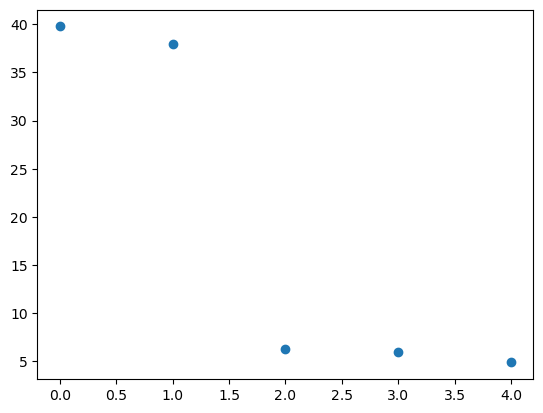

In [35]:
plt.scatter(np.arange(len(cond_numb_list)), cond_numb_list)